# 1 PRICE AND ELASTICITY OF DEMAND

## 1.1 IMPORTS, FUNCTIONS AND LOAD

### 1.1.1 Imports

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import statsmodels.api as sm
from statsmodels.formula.api import ols
import datetime 
from scipy import stats
import scipy
from sklearn.preprocessing import PowerTransformer
import warnings
warnings.filterwarnings("ignore")



### 1.1.2 Functions

In [4]:

def bar_plot(data, x, y, title, xlabel, ylabel, rotation=0, palette='rocket',figsize = (20,10)):
    """
    Summary: This function plots a barplot in a giving configuration.

    Args: 
        data: the dataset we want to plot.
        x: the column for the x axis.
        y: the column for the y axis.
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
        rotation: the rotation of the labels. default as 0.
        palette: the color palette. default as 'rocket'
        fisize: size of the figure.

    Returns: None
    """
    plt.figure(figsize=figsize)
    sns.barplot(data=data, x=x, y=y, palette=palette)

    plt.title(title)
    plt.xlabel(xlabel, color='black')
    plt.ylabel(ylabel, color='black')
    plt.xticks(rotation=rotation)
    plt.tick_params(left=False, bottom=False);

    return None



def set_image(title, xlabel, ylabel, rotation=0, ylim=None, yscale='linear', grid=True):
    """
    Summary: This function sets the image configuration.

    Args:
        title: the title of the plot.
        xlabel: the label for the x axis.
        ylabel: the label for the y axis.
        rotation: the rotation of the labels. default as 0.
        ylim: a tuple (min, max) to set the limits for the y axis. default as None.
        yscale: the scale of the y axis, 'linear' or 'log'. default as 'linear'.
        grid: boolean to show grid. default as True.

    Returns: None
    """

    plt.title(title)
    plt.xlabel(xlabel, color='black')
    plt.ylabel(ylabel, color='black')
    plt.xticks(rotation=rotation)
    plt.yscale(yscale)
    plt.tick_params(left=False, bottom=False)
    
    if ylim is not None:
        plt.ylim(ylim)

    if grid:
        plt.grid(True, which='both', linestyle='--', linewidth=0.5)

    return None



def process_outliers(df):
    """
     Processes outliers in a DataFrame through identification, removal, logarithmic transformation and winsorization.

     Parameters:
     -----------
     df : pandas.DataFrame
     The DataFrame containing the data to be processed.


     Applies winsorization to limit the values ​​of a series to within specified percentiles.

     Parameters:
     -----------
     series : pandas.Series
     The series to be winsorized.
     lower_percentile : float
     The bottom percentile for the cutoff.
     upper_percentile : float
     The top percentile for the cut.

     Returns:
     --------
     pandas.Series
     The series with winsorized values.   
    """
    def cap_values(series, lower_percentile, upper_percentile):
        
        
        lower_limit = series.quantile(lower_percentile)
        upper_limit = series.quantile(upper_percentile)
        return np.clip(series, lower_limit, upper_limit)

    #  Z-Score to identify outliers
    z_scores = np.abs(stats.zscore(df))
    outliers = np.where(z_scores > 3)
    
    # Removing outliers
    df_cleaned = df[(z_scores < 3).all(axis=1)]
    
    # Applying transformation Log
    df_transformed = df_cleaned.apply(lambda x: np.log(x + 1))
    
    # Winsorizing
    for column in df_transformed.columns:
        df_transformed[column] = cap_values(df_transformed[column], 0.01, 0.99)
        
    # Applying Yeo-Johnson transformation
    pt = PowerTransformer(method='yeo-johnson')
    df_transformed = pd.DataFrame(pt.fit_transform(df_cleaned), columns=df_cleaned.columns)
    
    return df_transformed







### 1.1.3 The dataset

Dataset with 10k entries was created based on Kaggle dataset: original dataset link: https://l1nq.com/v9kBX

For details see DataDictionary.txt


In [10]:
df = pd.read_csv ('dataset_price_demand_elasticity_10k_items.csv')
df.columns

Index(['purchasecod', 'codclient', 'date_purchase', 'sales_channel', 'codprod',
       'product', 'price', 'category_name', 'brand', 'disc_perc', 'total'],
      dtype='object')

In [7]:
df1 = df.copy()

In [9]:
features = df1 [['price','disc_perc', 'total']]
features.describe ()

,price,disc_perc,total
count,10000.000000,10000.000000,10000.000000
mean,479.734609,0.017068,479.498065
std,781.907941,0.080201,780.994370
min,1.000000,0.000000,1.000000
25%,79.545000,0.000000,79.525000
50%,179.990000,0.000000,179.990000
75%,399.990000,0.000000,399.990000
max,5199.990000,0.800000,5182.830000


In [10]:
skewness = features.apply(lambda x: x.skew())
kurtosis = features.apply(lambda x: x.kurtosis())

df_graph1 = pd.DataFrame({'Skewness': skewness, 'Kurtosis': kurtosis})

df_graph1 = process_outliers (df_graph1)
df_graph1

,Skewness,Kurtosis
0,-0.699589,-0.695506
1,1.414187,1.414150
2,-0.714598,-0.718645


## 1.2 EXPLORATORY DATA ANALYSIS

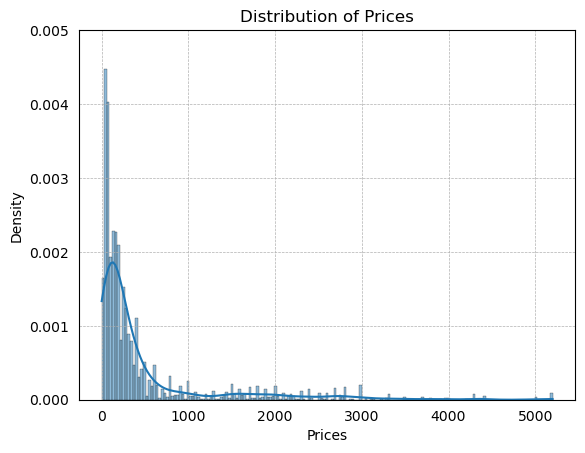

In [11]:
# Look out the price distribution
sns.histplot(df['price'], kde=True, stat='density')

set_image('Distribution of Prices', 'Prices', 'Density', rotation=0, ylim=(0,0.005), yscale='linear', grid=True)

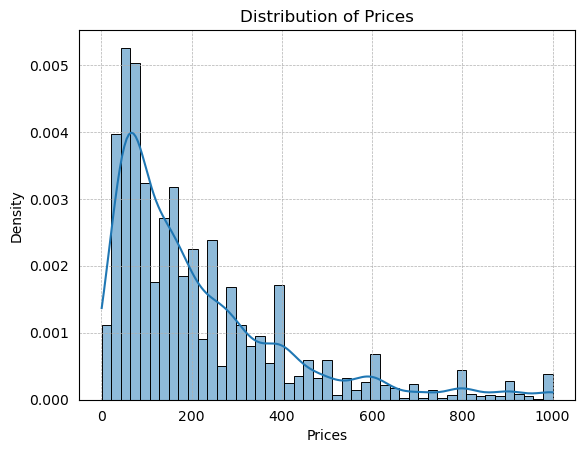

In [12]:
# Select a range below 1000
df_graph2 = df1.loc[df1['price'] <= 1000, :]

sns.histplot(df_graph2['price'], kde=True, stat='density')

set_image('Distribution of Prices', 'Prices', 'Density')

Which channel sold most?

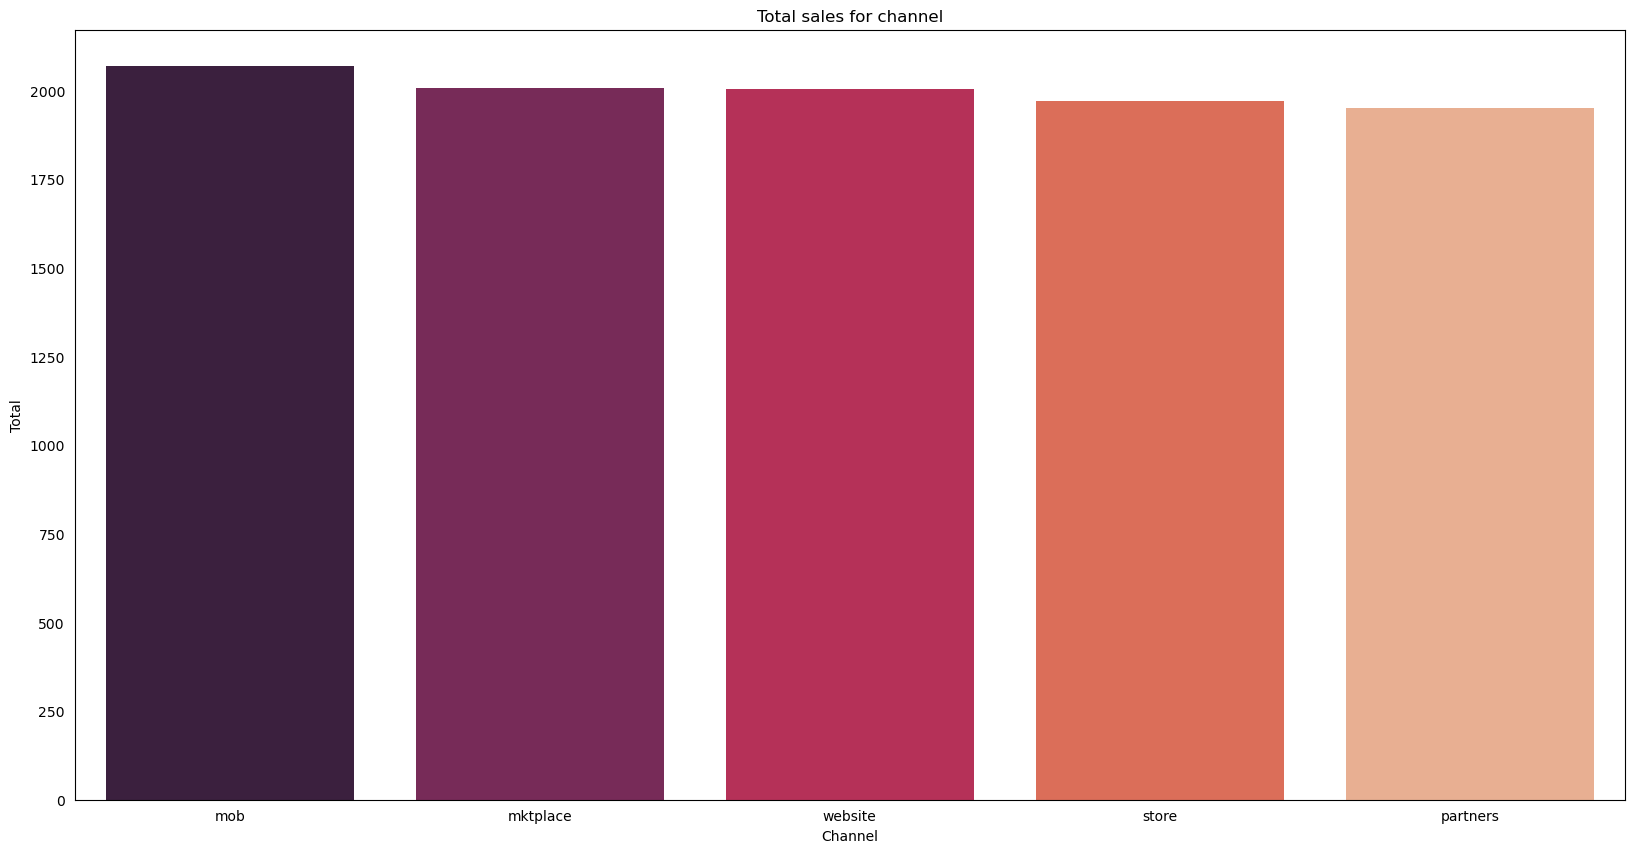

In [14]:
# The distribution of sales in each channel 
df_graph3  = df1[['date_purchase', 'sales_channel']].groupby(['sales_channel']).count().reset_index().sort_values(by='date_purchase', ascending=False)

fig1    = bar_plot(df_graph3, 'sales_channel', 'date_purchase', 'Total sales for channel', 'Channel', 'Total')

Which category sold the most?

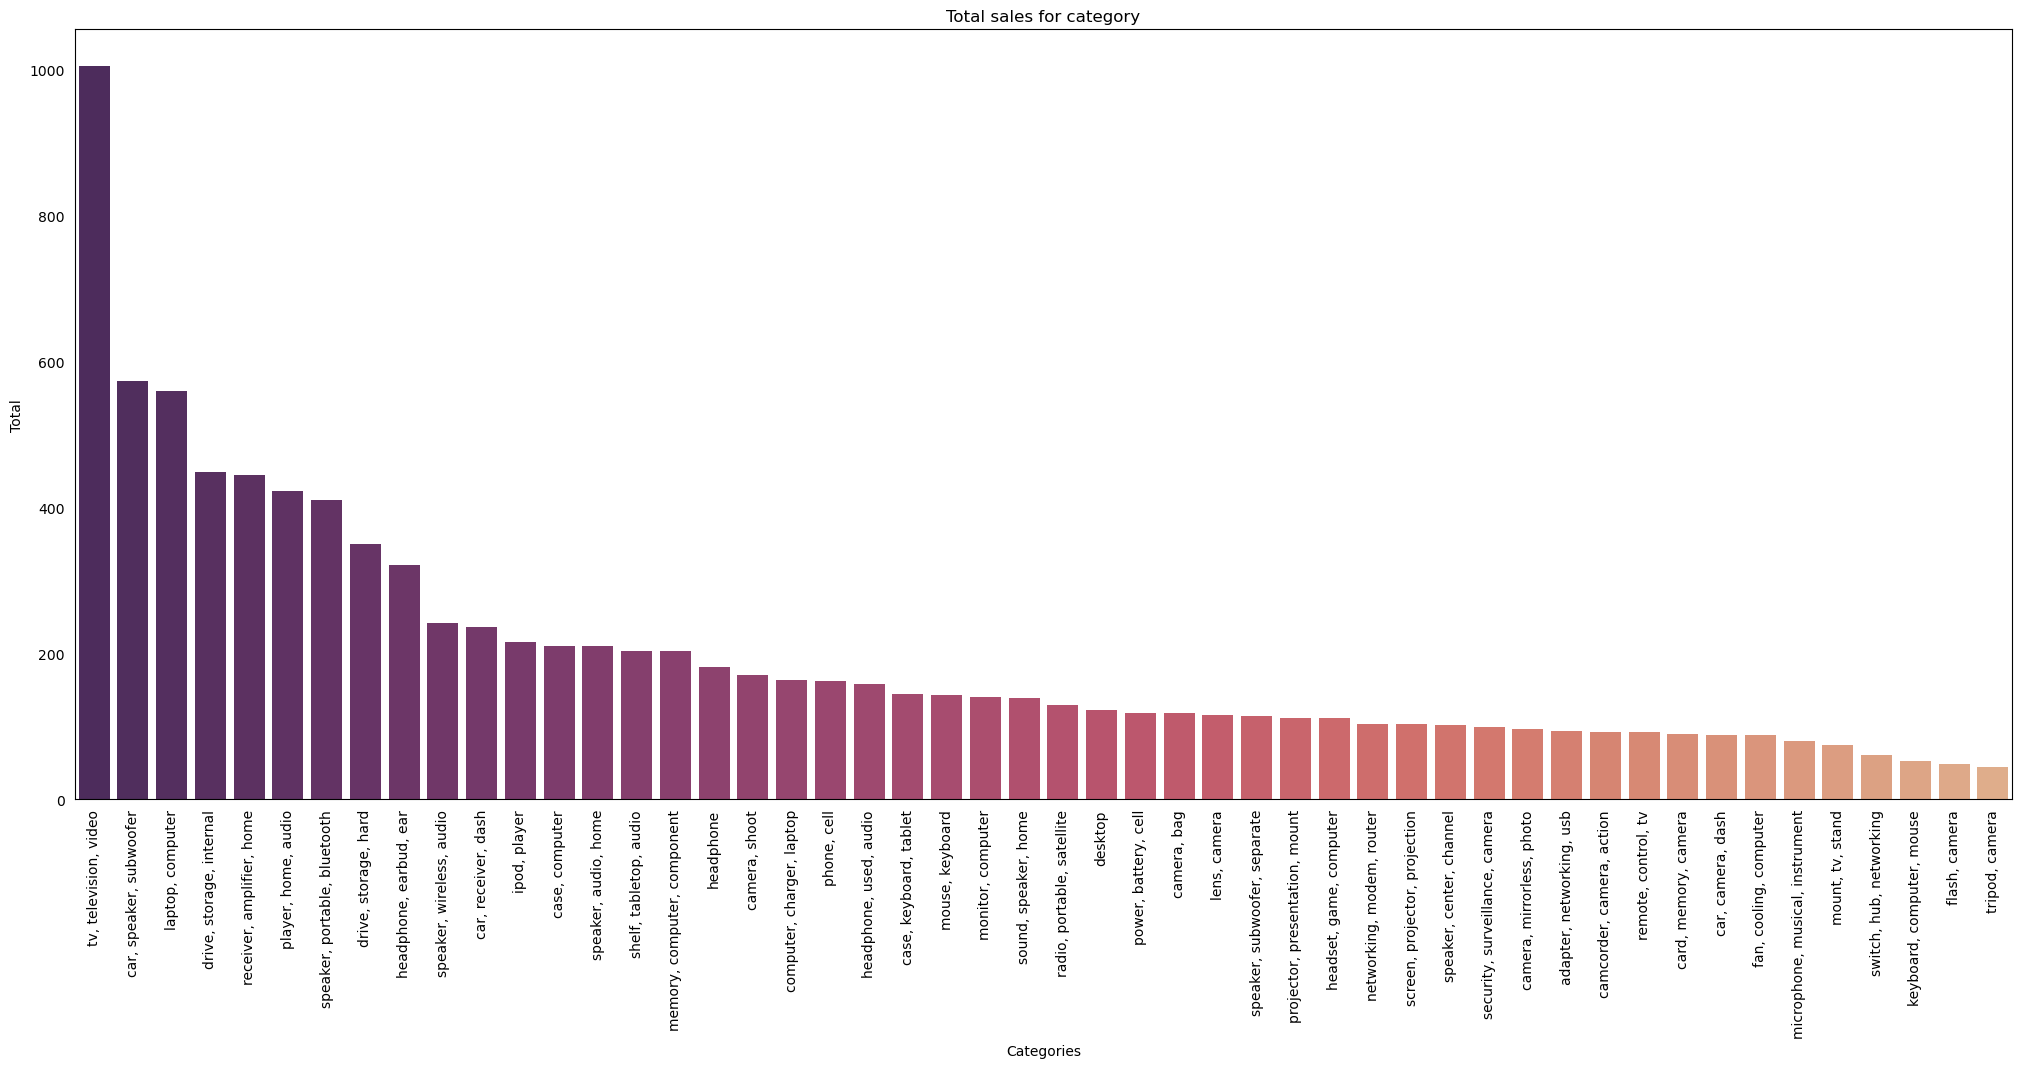

In [16]:

df1 ['date_purchase_str'] = df1['date_purchase'].astype(str)
df_agg = df1[['date_purchase', 'category_name']].groupby(['category_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
df_agg.rename(columns={'date_purchase': 'Total'}, inplace=True)



df_graph4 = df_agg[['Total', 'category_name']].groupby(['category_name']).count().reset_index().sort_values(by='Total', ascending=False)

fig2    = bar_plot(df_graph4.head(50), 'category_name', 'Total', 'Total sales for category', 'Categories', 'Total', 90, 'flare_r',figsize=(25,10))

Wich category sold most for channel?

In [182]:
# Creating datasets for channel
df1_mob = df1.query ('sales_channel == "mob"')
df1_partners = df1.query ('sales_channel == "partners"')
df1_mktplace = df1.query ('sales_channel == "mktplace"')
df1_website = df1.query ('sales_channel == "website"')
df1_store = df1.query ('sales_channel == "store"')


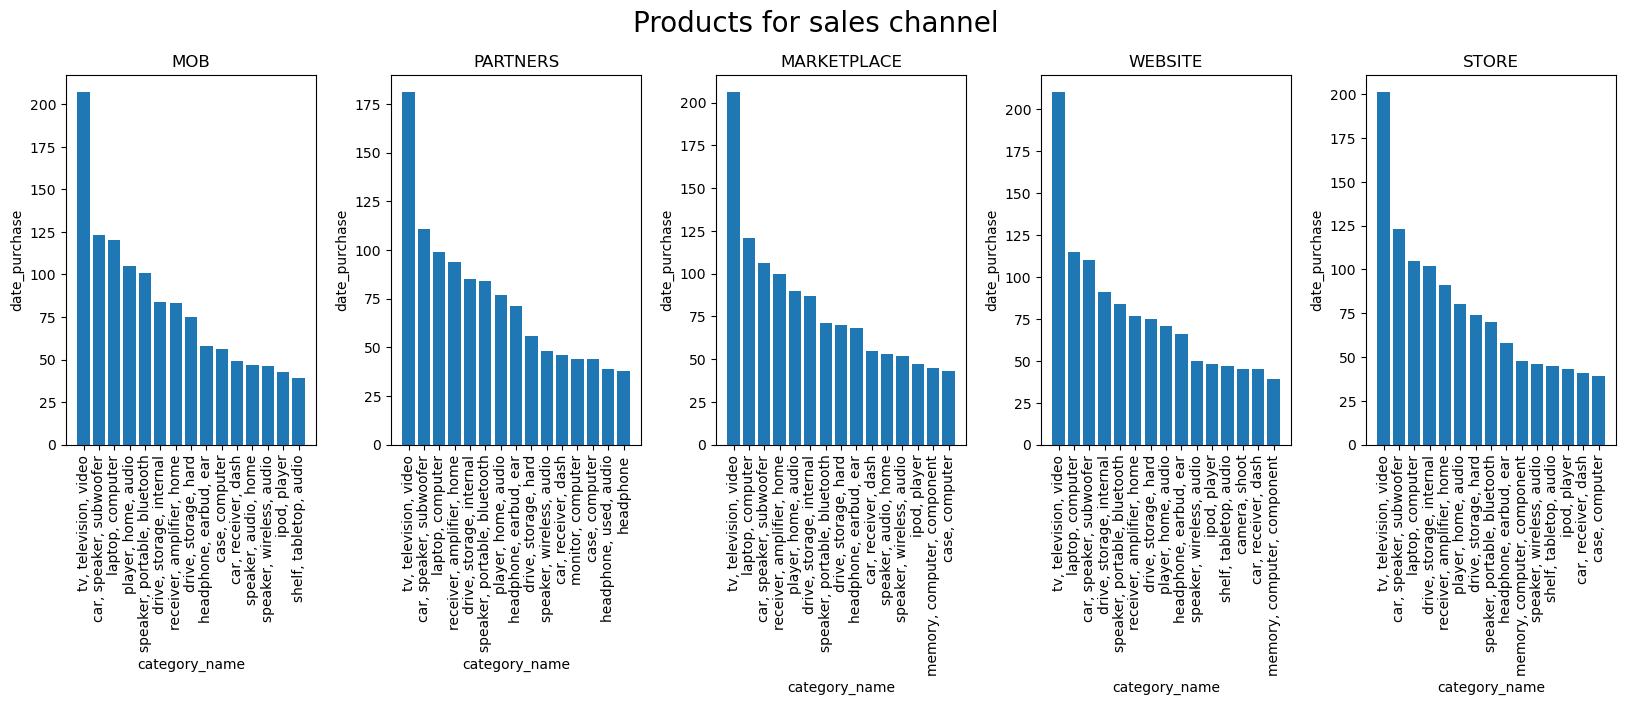

In [184]:
import matplotlib.pyplot as plt

# Specific function for this cell
def bar_plot_local(data, x, y, title, xlabel, ylabel, rotation, ax):
    ax.bar(data[x], data[y])
    ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    ax.tick_params(axis='x', rotation=rotation)

# Creating a canvas
fig7, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))  

# Ploting subplots
df_plot1 = df1_mob[['date_purchase', 'category_name']].groupby(['category_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot1.head(15), 'category_name', 'date_purchase', 'MOB', None, None, 90, axes[0])

df_plot2 = df1_partners[['date_purchase', 'category_name']].groupby(['category_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot2.head(15), 'category_name', 'date_purchase', 'PARTNERS', None, None, 90, axes[1])

df_plot3 = df1_mktplace[['date_purchase', 'category_name']].groupby(['category_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot3.head(15), 'category_name', 'date_purchase', 'MARKETPLACE', None, None, 90, axes[2])

df_plot4 = df1_website[['date_purchase', 'category_name']].groupby(['category_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot4.head(15), 'category_name', 'date_purchase', 'WEBSITE', None, None, 90, axes[3])

df_plot5 = df1_store[['date_purchase', 'category_name']].groupby(['category_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot5.head(15), 'category_name', 'date_purchase', 'STORE', None, None, 90, axes[4])

# Main title
fig7.suptitle('Products for sales channel', fontsize=20)

fig7.subplots_adjust(top=0.85, wspace=0.3)  

plt.show()


Which brand sold most?

In [21]:
# Identify week day
df1['date_purchase'] = pd.to_datetime(df1['date_purchase'])
df1['week_day'] = df1['date_purchase'].dt.day_name()

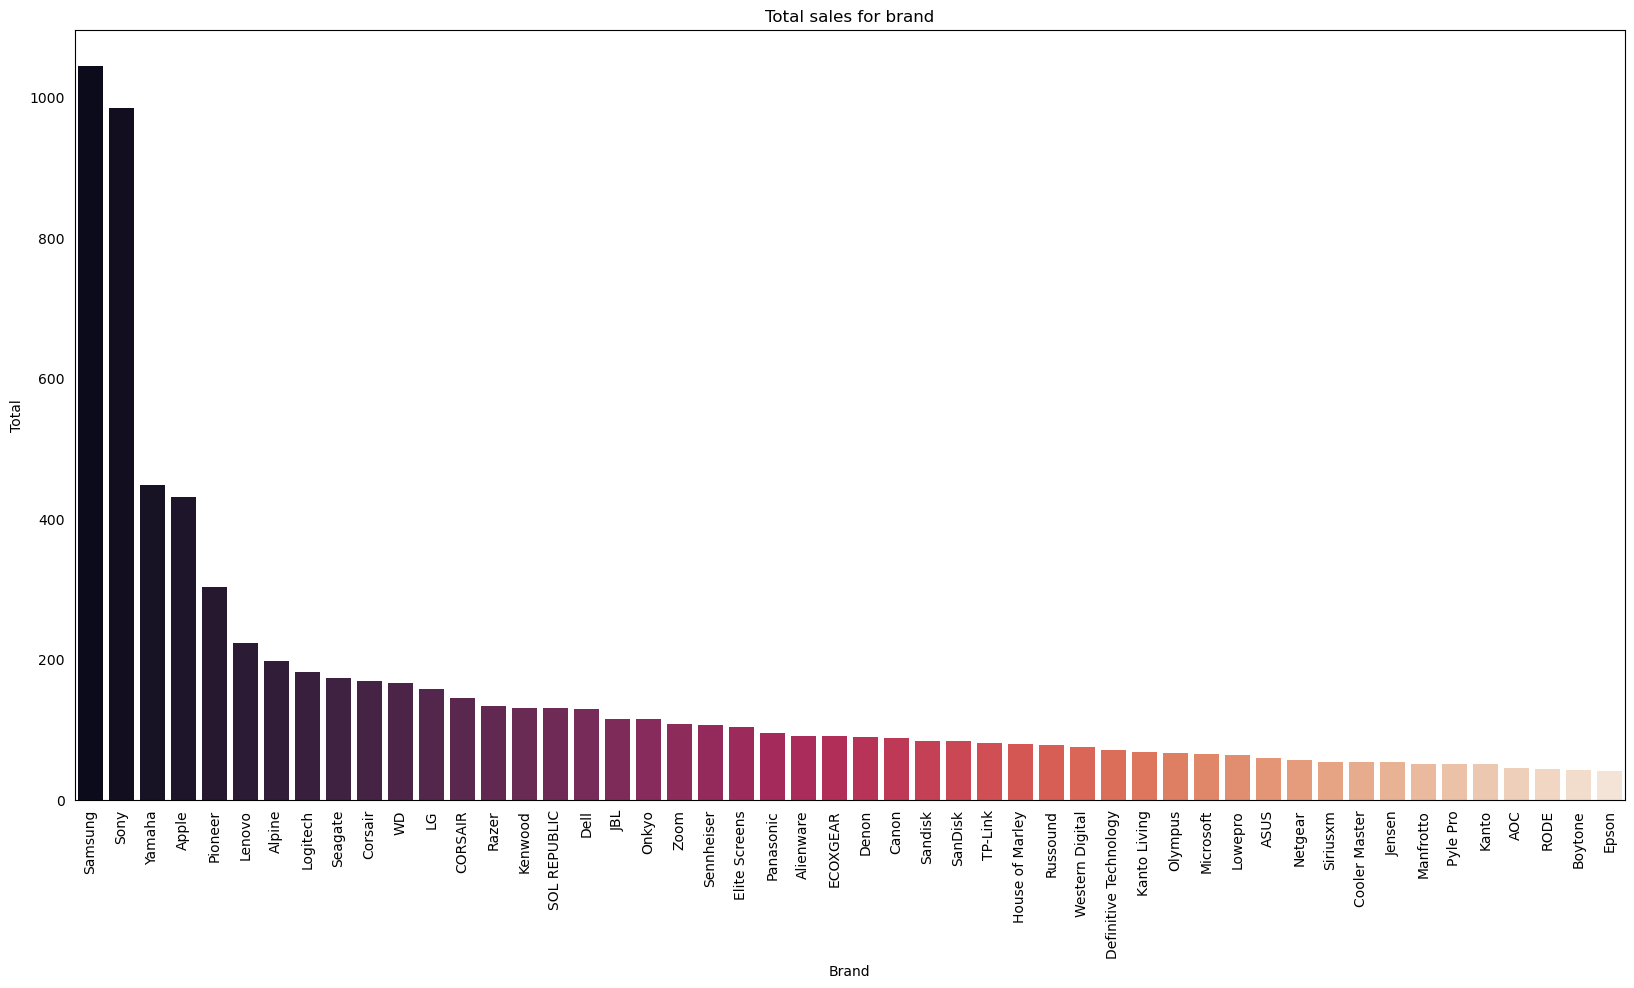

In [22]:
df_graph5 = df1[['date_purchase', 'brand']].groupby(['brand']).count().reset_index().sort_values(by='date_purchase', ascending=False)

fig4 = bar_plot(df_graph5.head(50), 'brand', 'date_purchase', 'Total sales for brand', 'Brand', 'Total', 90)

In [23]:
df1_samsung = df1.query ('brand == "Samsung"')

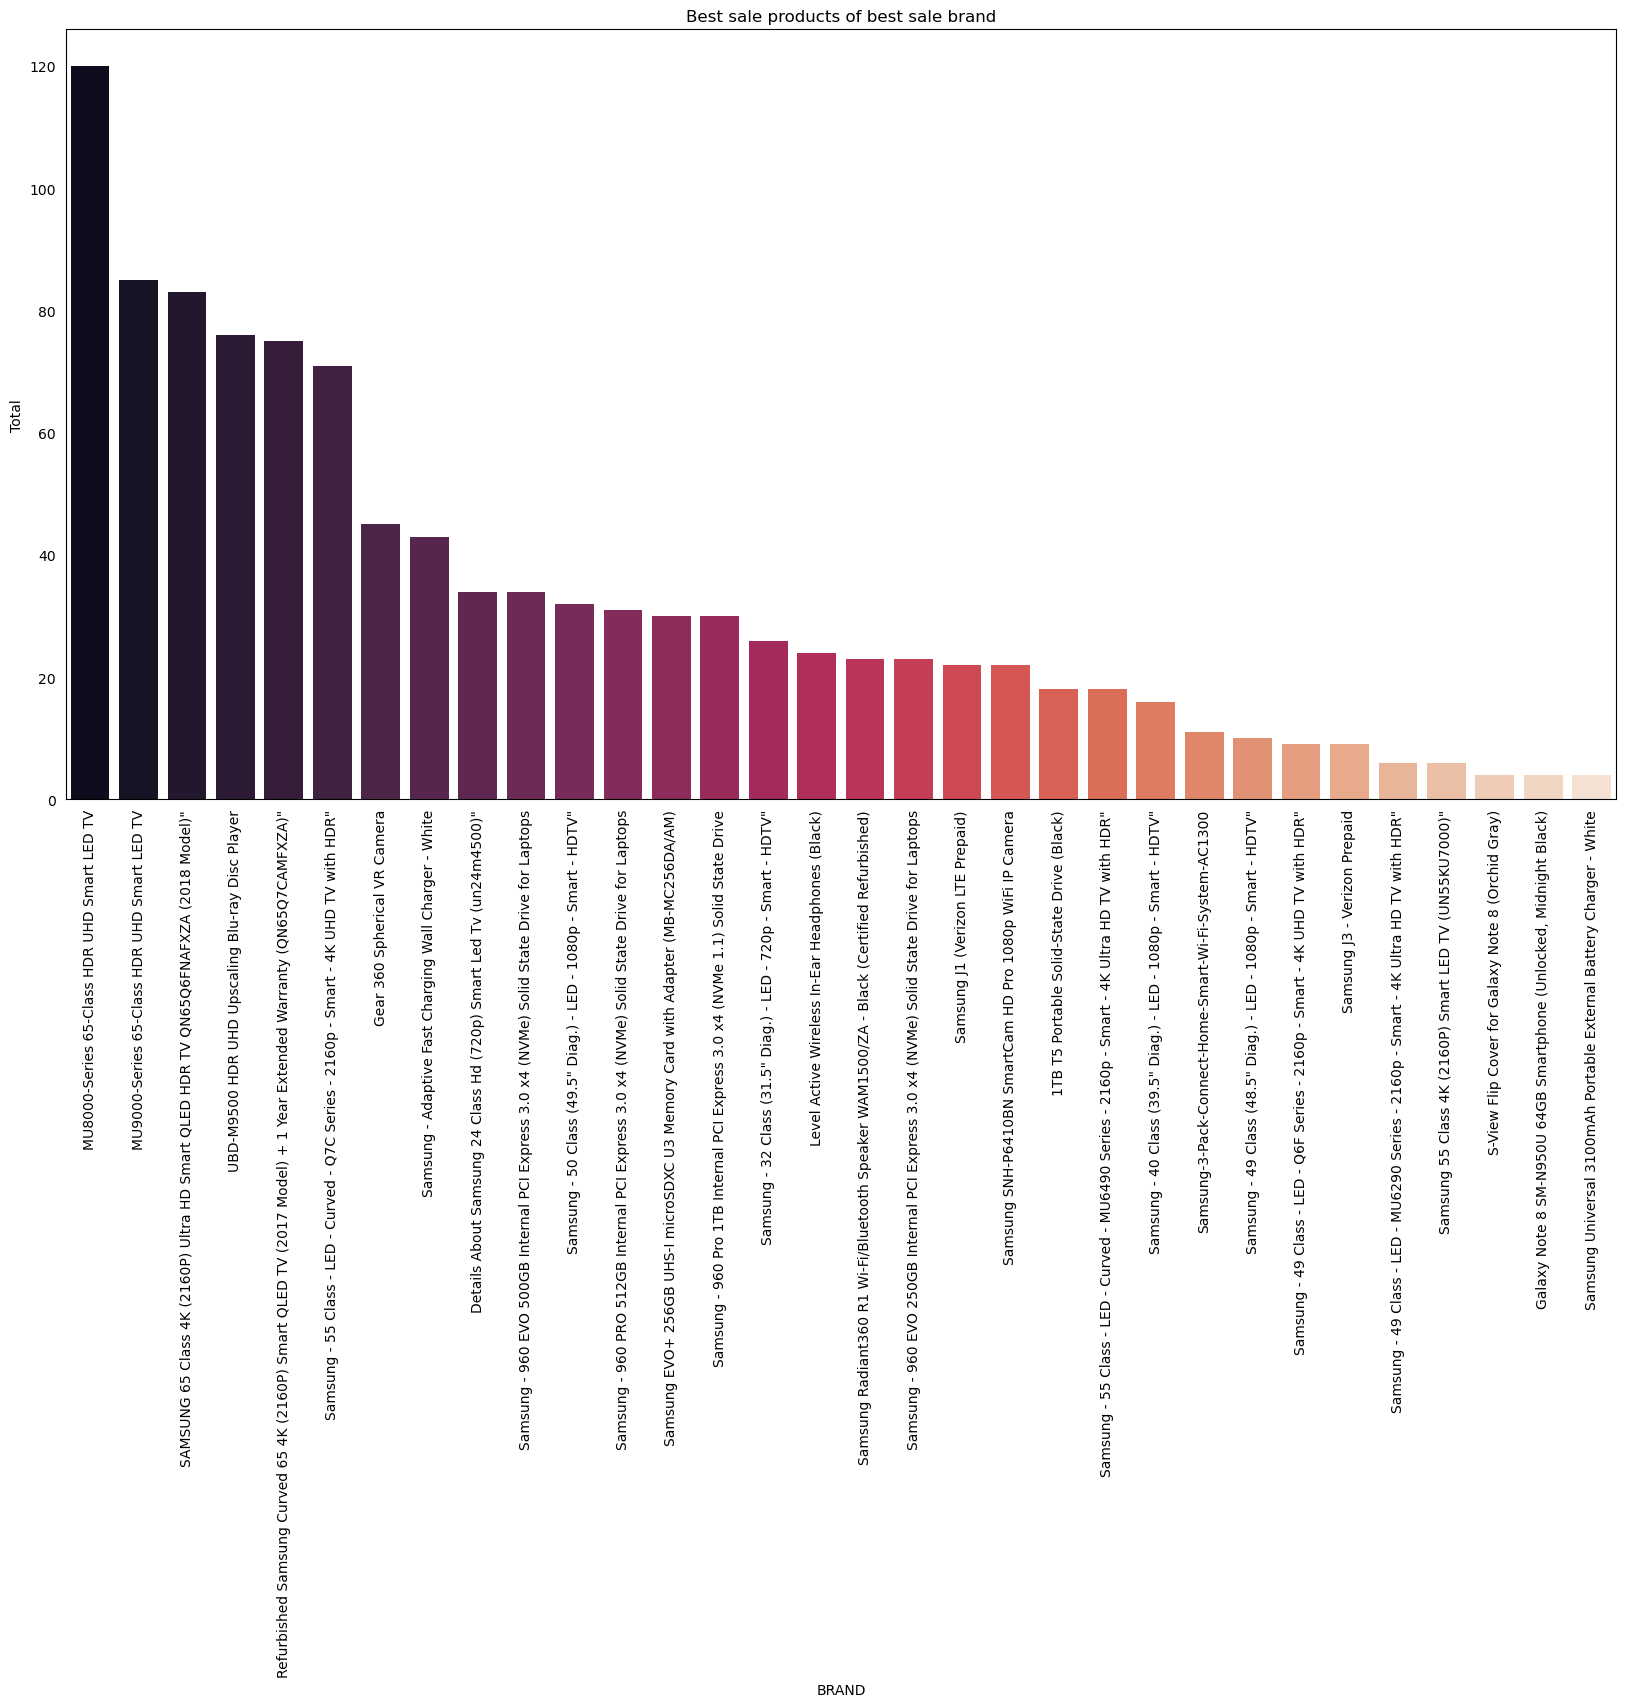

In [24]:
df_graph6 = df1_samsung[['date_purchase', 'product']].groupby(['product']).count().reset_index().sort_values(by='date_purchase', ascending=False)

fig5 = bar_plot(df_graph6.head(50), 'product', 'date_purchase', 'Best sale products of best sale brand', 'BRAND', 'Total', 90)

Which week day sold most?

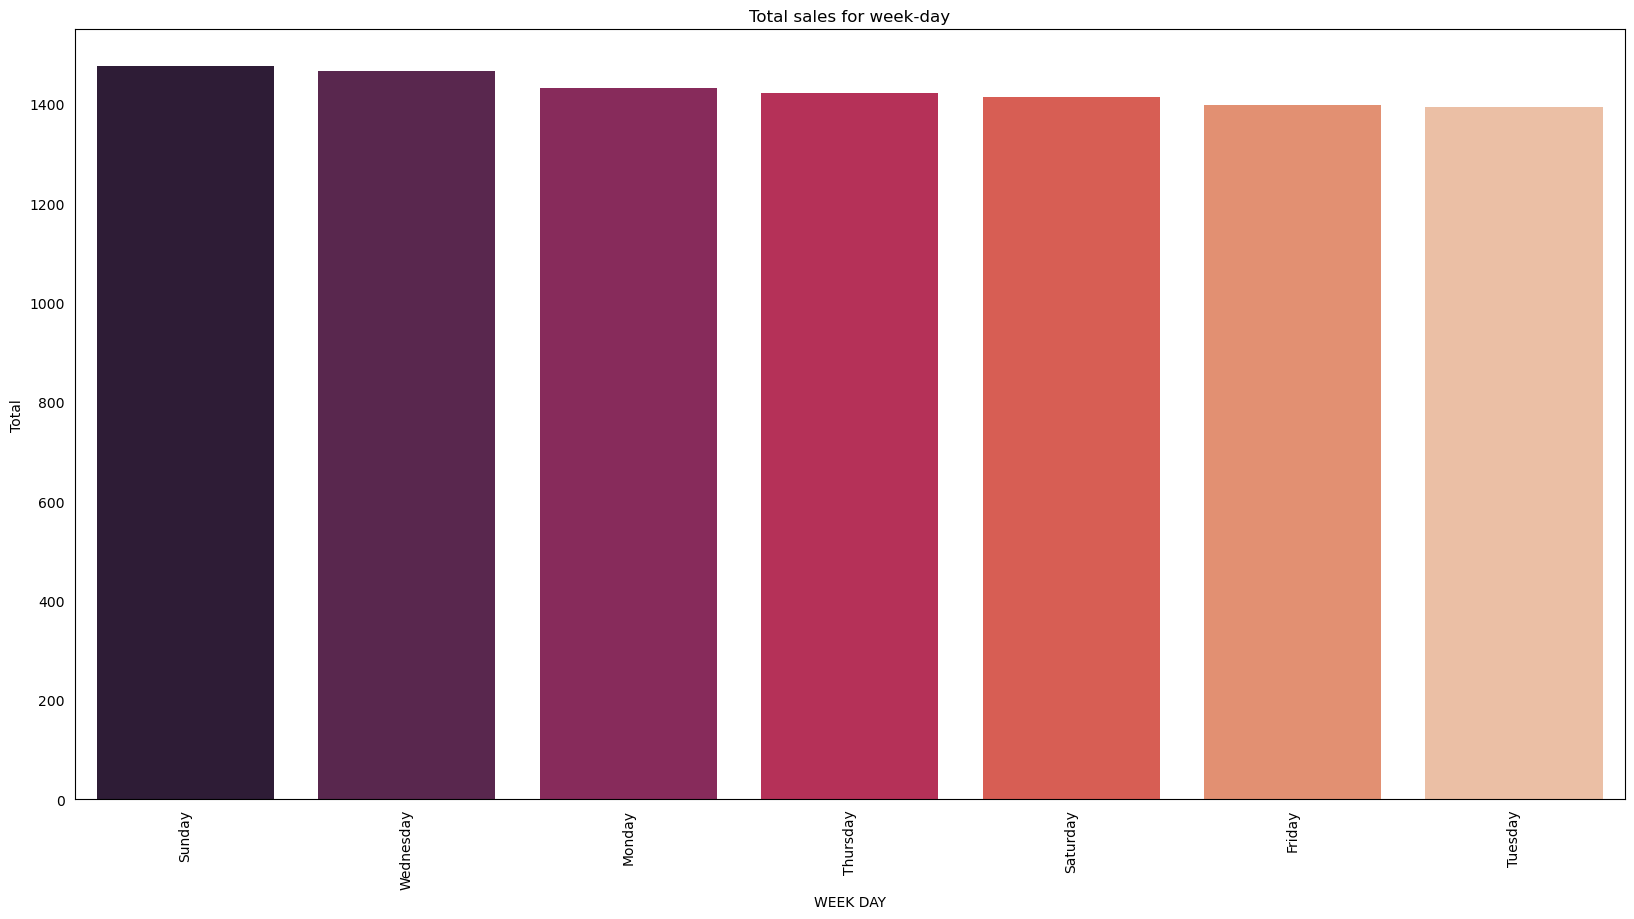

In [26]:
df_graph7 = df1[['date_purchase', 'week_day']].groupby(['week_day']).count().reset_index().sort_values(by='date_purchase', ascending=False)

fig6 = bar_plot(df_graph7, 'week_day', 'date_purchase', 'Total sales for week-day', 'WEEK DAY', 'Total', 90)

Which channel sold most for week day?

In [28]:
# updating datasets
df1_mob = df1.query ('sales_channel == "mob"')
df1_partners = df1.query ('sales_channel == "partners"')
df1_mktplace = df1.query ('sales_channel == "mktplace"')
df1_website = df1.query ('sales_channel == "website"')
df1_store = df1.query ('sales_channel == "store"')


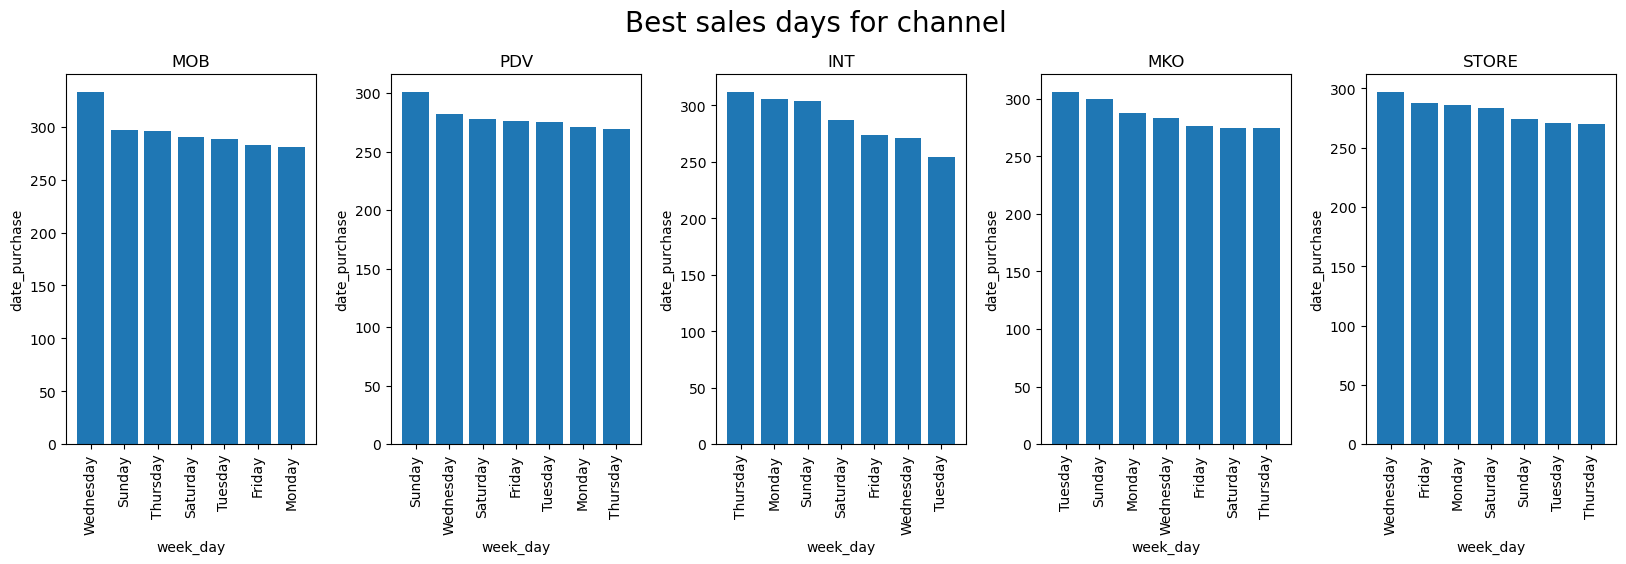

In [29]:
# Local plot
def bar_plot_local(data, x, y, title, xlabel, ylabel, rotation, ax):
    ax.bar(data[x], data[y])
    ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    ax.tick_params(axis='x', rotation=rotation)

# Creating a canvas
fig7, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))  

# Ploting subplot
df_plot1 = df1_mob[['date_purchase', 'week_day']].groupby(['week_day']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot1, 'week_day', 'date_purchase', 'MOB', None, None, 90, axes[0])

df_plot2 = df1_partners[['date_purchase', 'week_day']].groupby(['week_day']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot2, 'week_day', 'date_purchase', 'PDV', None, None, 90, axes[1])

df_plot3 = df1_mktplace[['date_purchase', 'week_day']].groupby(['week_day']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot3, 'week_day', 'date_purchase', 'INT', None, None, 90, axes[2])

df_plot4 = df1_website[['date_purchase', 'week_day']].groupby(['week_day']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot4, 'week_day', 'date_purchase', 'MKO', None, None, 90, axes[3])

df_plot5 = df1_store[['date_purchase', 'week_day']].groupby(['week_day']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot5, 'week_day', 'date_purchase', 'STORE', None, None, 90, axes[4])


# Main title
fig7.suptitle('Best sales days for channel', fontsize=20)

fig7.subplots_adjust(top=0.85, wspace=0.3)  # Ajuste `wspace` conforme necessário

plt.show()


Which month sold most?

In [31]:
# Create a new feature 'month_name'
df1['month_name'] = df1['date_purchase'].dt.month_name()


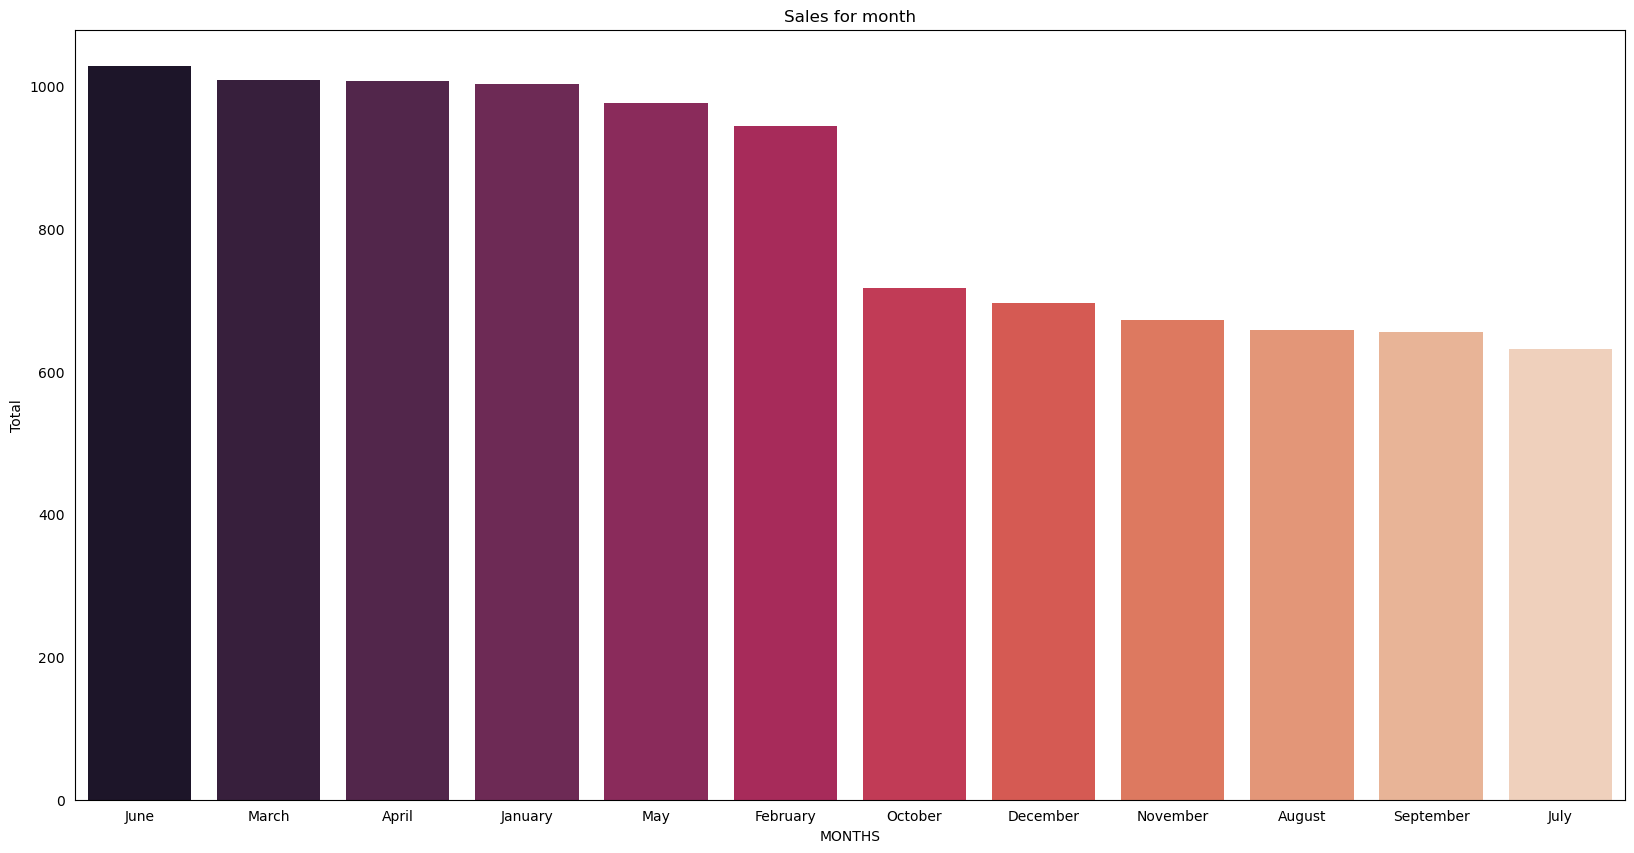

In [32]:
df_graph8 = df1[['date_purchase', 'month_name']].groupby(['month_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)

fig8 = bar_plot(df_graph8, 'month_name', 'date_purchase', 'Sales for month', 'MONTHS', 'Total',0)

Which  month sold most for channel?

In [34]:
# updating datasets
df1_mob = df1.query ('sales_channel == "mob"')
df1_partners = df1.query ('sales_channel == "partners"')
df1_mktplace = df1.query ('sales_channel == "mktplace"')
df1_website = df1.query ('sales_channel == "website"')
df1_store = df1.query ('sales_channel == "store"')


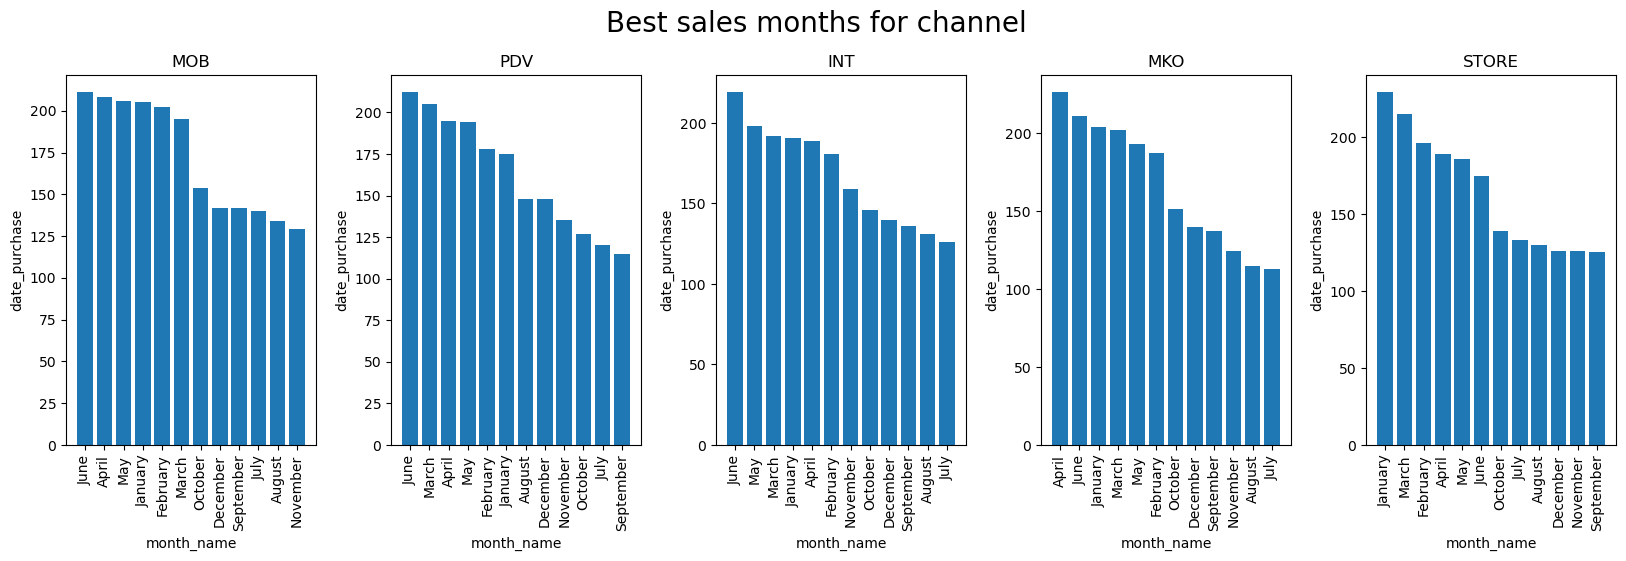

In [35]:
# Local function
def bar_plot_local(data, x, y, title, xlabel, ylabel, rotation, ax):
    ax.bar(data[x], data[y])
    ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    ax.tick_params(axis='x', rotation=rotation)

# Creating a canvas
fig9, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))  

# Ploting subplot
df_plot1 = df1_mob[['date_purchase', 'month_name']].groupby(['month_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot1, 'month_name', 'date_purchase', 'MOB', None, None, 90, axes[0])

df_plot2 = df1_partners[['date_purchase', 'month_name']].groupby(['month_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot2, 'month_name', 'date_purchase', 'PDV', None, None, 90, axes[1])

df_plot3 = df1_mktplace[['date_purchase', 'month_name']].groupby(['month_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot3, 'month_name', 'date_purchase', 'INT', None, None, 90, axes[2])

df_plot4 = df1_website[['date_purchase', 'month_name']].groupby(['month_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot4, 'month_name', 'date_purchase', 'MKO', None, None, 90, axes[3])

df_plot5 = df1_store[['date_purchase', 'month_name']].groupby(['month_name']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot5, 'month_name', 'date_purchase', 'STORE', None, None, 90, axes[4])


# Main title
fig9.suptitle('Best sales months for channel', fontsize=20)

fig9.subplots_adjust(top=0.85, wspace=0.3)  # Ajuste `wspace` conforme necessário

plt.show()


Which week sold most?


In [186]:
# Create a new feature 'week' with the number of week in year
df1['week_number'] = df1['date_purchase'].dt.isocalendar().week


# updating datasets
df1_mob = df1.query ('sales_channel == "mob"')
df1_partners = df1.query ('sales_channel == "partners"')
df1_mktplace = df1.query ('sales_channel == "mktplace"')
df1_website = df1.query ('sales_channel == "website"')
df1_store = df1.query ('sales_channel == "store"')


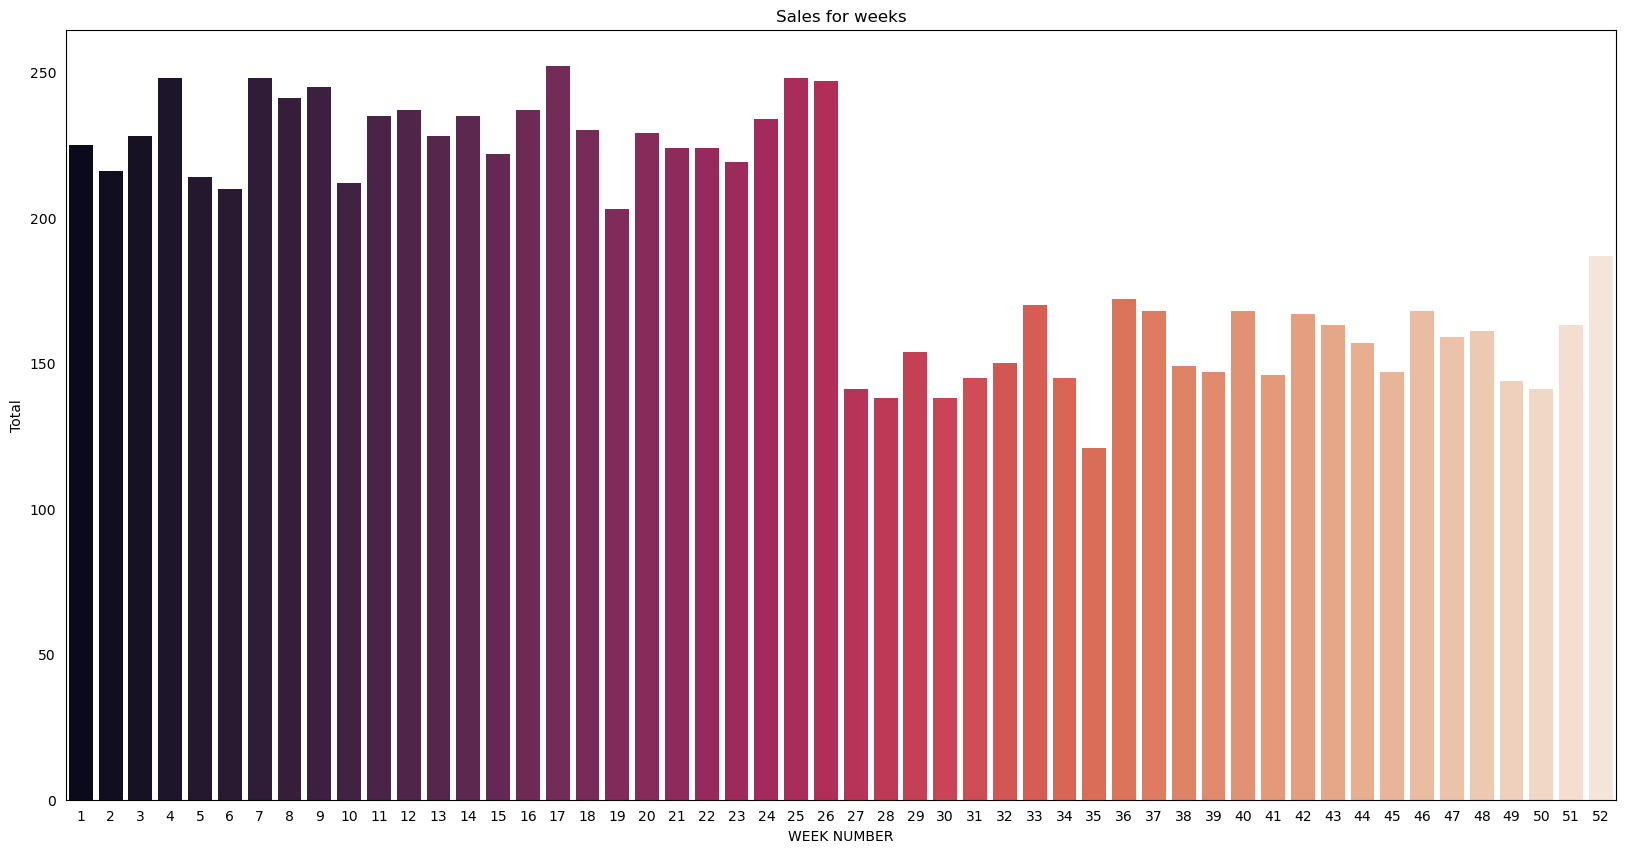

In [38]:
df_graph10 = df1[['date_purchase', 'week_number']].groupby(['week_number']).count().reset_index().sort_values(by='date_purchase', ascending=False)

fig10 = bar_plot(df_graph10, 'week_number', 'date_purchase', 'Sales for weeks', 'WEEK NUMBER', 'Total',0)

Most sold weeks for channel

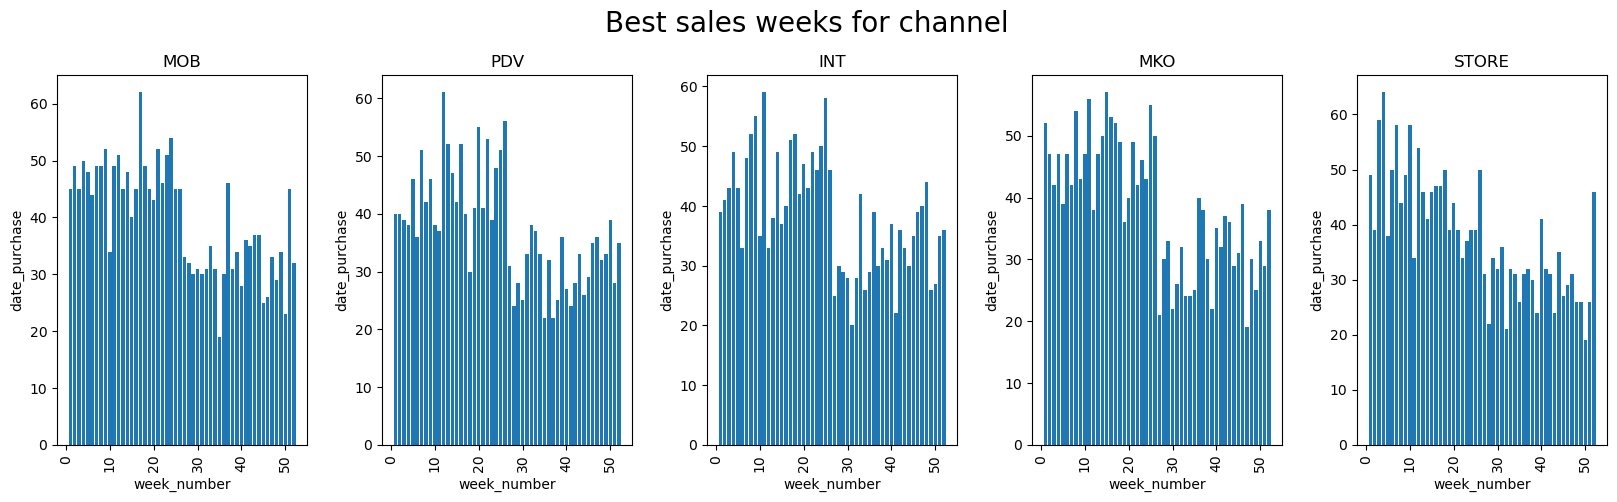

In [40]:
# Local function
def bar_plot_local(data, x, y, title, xlabel, ylabel, rotation, ax):
    ax.bar(data[x], data[y])
    ax.set_title(title)
    ax.set_xlabel(xlabel if xlabel else x)
    ax.set_ylabel(ylabel if ylabel else y)
    ax.tick_params(axis='x', rotation=rotation)

# Creating a canvas
fig12, axes = plt.subplots(nrows=1, ncols=5, figsize=(20, 5))  

# Ploting subplot
df_plot1 = df1_mob[['date_purchase', 'week_number']].groupby(['week_number']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot1, 'week_number', 'date_purchase', 'MOB', None, None, 90, axes[0])

df_plot2 = df1_partners[['date_purchase', 'week_number']].groupby(['week_number']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot2, 'week_number', 'date_purchase', 'PDV', None, None, 90, axes[1])

df_plot3 = df1_mktplace[['date_purchase', 'week_number']].groupby(['week_number']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot3, 'week_number', 'date_purchase', 'INT', None, None, 90, axes[2])

df_plot4 = df1_website[['date_purchase', 'week_number']].groupby(['week_number']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot4, 'week_number', 'date_purchase', 'MKO', None, None, 90, axes[3])

df_plot5 = df1_store[['date_purchase', 'week_number']].groupby(['week_number']).count().reset_index().sort_values(by='date_purchase', ascending=False)
bar_plot_local(df_plot5, 'week_number', 'date_purchase', 'STORE', None, None, 90, axes[4])


# Main title
fig12.suptitle('Best sales weeks for channel', fontsize=20)

fig12.subplots_adjust(top=0.85, wspace=0.3)  # Ajuste `wspace` conforme necessário

plt.show()


## 1.3 FEATURE ENGINEERING

Samsung was the most sold brand and the most sold product was "Smart LED TV"


In [188]:
# updating "df1_samsung" with 'week_day', 'month_name', 'week_number'

df1_samsung = df1.query ('brand == "Samsung"')

# Dealing with spaces in strings and searching
df1_samsung['product'] = df1_samsung['product'].str.strip()

smart_tv = df1_samsung[df1_samsung['product'].str.contains('Smart LED tv', case=False, na=False)]['product'].unique().tolist()

print('There are {} in Smart LED tv.'.format(len(smart_tv)),'\n')

for i in smart_tv:
    print(i)


There are 4 in Smart LED tv. 

Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)"
Samsung 55 Class 4K (2160P) Smart LED TV (UN55KU7000)"
MU8000-Series 65-Class HDR UHD Smart LED TV
MU9000-Series 65-Class HDR UHD Smart LED TV


vendas de smart tvs por semana

In [53]:
# dataset smart_tv_1


smart_tv_1 = df1_samsung[df1_samsung['product'].str.contains('Smart LED tv', case=False, na=False)]

smart_tv_1 = smart_tv_1.groupby(['product', 'week_number']).agg({'price': 'mean', 'date_purchase': 'count'}).reset_index()

smart_tv_1

,product,week_number,price,date_purchase
0,Details About Samsung 24 Class Hd (720p) Smart...,1,149.49,2
1,Details About Samsung 24 Class Hd (720p) Smart...,2,159.99,1
2,Details About Samsung 24 Class Hd (720p) Smart...,3,159.99,1
3,Details About Samsung 24 Class Hd (720p) Smart...,4,162.99,3
4,Details About Samsung 24 Class Hd (720p) Smart...,6,147.99,1
...,...,...,...,...
112,Samsung 55 Class 4K (2160P) Smart LED TV (UN55...,5,999.99,1
113,Samsung 55 Class 4K (2160P) Smart LED TV (UN55...,13,909.99,1
114,Samsung 55 Class 4K (2160P) Smart LED TV (UN55...,25,1.00,1
115,Samsung 55 Class 4K (2160P) Smart LED TV (UN55...,26,809.99,1


In [131]:
# pivoting price dataframe
x_price = smart_tv_1.pivot(index= 'week_number' , columns= 'product', values='price')
x_price = pd.DataFrame(x_price.to_records())

# pivoting demand dataframe 
y_demand = smart_tv_1.pivot(index= 'week_number' , columns= 'product', values='date_purchase')
y_demand = pd.DataFrame(y_demand.to_records())

## 1.4 PRICE-DEMAND DATA EXPLORATION

If the product is not sold, the price remains the same, and we can fill in the missing values with their respective median values. But unlike price, demand for the product on non-sale days is 0. Using the median to fill in missing price values because the median is more robust to price fluctuations

In [65]:
# Fill out with median
aux1 = x_price.median()
x_price.fillna(aux1, inplace=True)

# using zeros to fill out demand missing values
y_demand.fillna(0, inplace=True)

In [68]:
x_price.describe()

,week_number,"Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)""",MU8000-Series 65-Class HDR UHD Smart LED TV,MU9000-Series 65-Class HDR UHD Smart LED TV,"Samsung 55 Class 4K (2160P) Smart LED TV (UN55KU7000)"""
count,51.000000,51.000000,51.000000,51.000000,51.000000
mean,26.333333,164.010294,1870.618982,2435.988781,939.127451
std,15.257348,16.185200,267.942326,477.885728,140.313169
min,1.000000,140.990000,1368.990000,1887.950000,1.000000
25%,13.500000,159.990000,1698.323333,2033.325000,954.990000
50%,26.000000,159.990000,1827.740000,2296.083000,954.990000
75%,39.500000,159.990000,1916.541250,2648.495000,954.990000
max,52.000000,229.000000,2699.990000,3299.000000,1199.990000


In [72]:
ranges      = x_price.apply(lambda x: x.max() - x.min())
skewness    = x_price.apply(lambda x: x.skew())
kurtosis    = x_price.apply(lambda x: x.kurtosis())

df_aux      = pd.DataFrame({'Range': ranges, 'Skewness': skewness, 'Kurtosis': kurtosis})
df_aux

,Range,Skewness,Kurtosis
week_number,51.00,0.030511,-1.214974
"Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)""",88.01,2.010371,4.858882
MU8000-Series 65-Class HDR UHD Smart LED TV,1331.00,1.665081,3.651846
MU9000-Series 65-Class HDR UHD Smart LED TV,1411.05,0.801437,-0.606704
"Samsung 55 Class 4K (2160P) Smart LED TV (UN55KU7000)""",1198.99,-6.099387,42.161595


In [78]:
x_price.drop (columns = 'week_number', axis = 1, inplace = True)
y_demand.drop (columns = 'week_number', axis = 1, inplace = True)

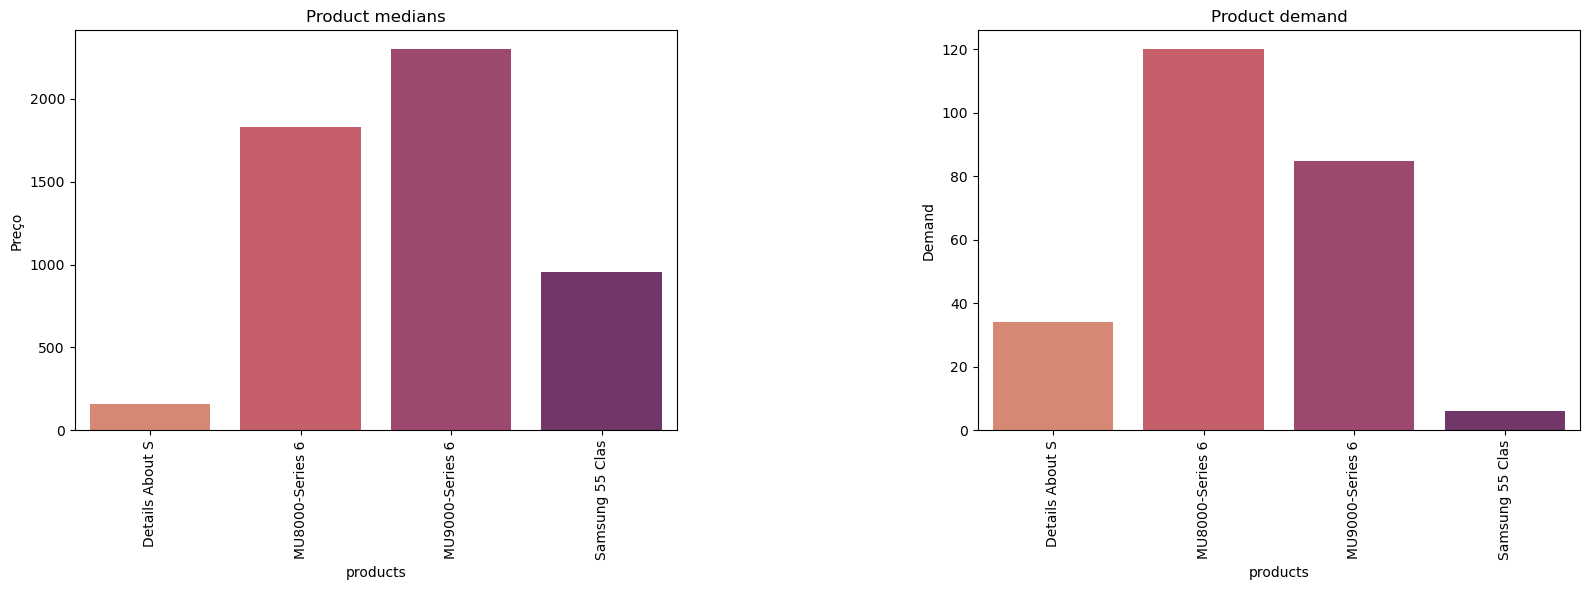

In [94]:
# Data manipulation
aux1 = pd.DataFrame(x_price.apply(lambda x: x.median())).reset_index()
aux1.columns = ['products', 'price']

aux2 = pd.DataFrame(y_demand.apply(lambda x: x.sum())).reset_index()
aux2.columns = ['products', 'demand']

# Truncate the product names
aux1['products'] = aux1['products'].apply(lambda x: x[:15])# + '...' + x[-45:] if len(x) > 60 else x)
aux2['products'] = aux2['products'].apply(lambda x: x[:15])# + '...' + x[-45:] if len(x) > 60 else x)

# Creating canvas with horizontal subplots
fig12, axes = plt.subplots(nrows=1, ncols=2, figsize=(16, 6))

# Plotting each subplot
sns.barplot(data=aux1, x='products', y='price', palette='flare', ax=axes[0])
axes[0].set_title('Product medians')
axes[0].set_ylabel('Preço')
axes[0].tick_params(axis='x', rotation=90)  # Rotação das labels no eixo x

sns.barplot(data=aux2, x='products', y='demand', palette='flare', ax=axes[1])
axes[1].set_title('Product demand')
axes[1].set_ylabel('Demand')
axes[1].tick_params(axis='x', rotation=90)  # Rotação das labels no eixo x

# Ajuste do layout e espaçamento
plt.tight_layout()
plt.subplots_adjust(wspace=0.5)  

# Show the figure
plt.show()


In [103]:
x_price.head(3)

,"Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)""",MU8000-Series 65-Class HDR UHD Smart LED TV,MU9000-Series 65-Class HDR UHD Smart LED TV,"Samsung 55 Class 4K (2160P) Smart LED TV (UN55KU7000)"""
0,149.49,1672.99,2296.083,954.99
1,159.99,2148.47,2068.660,954.99
2,159.99,1614.95,2337.080,1199.99


## 1.5 PRICE ELASTICITY

### 1.5.1 Regression Analysis: Ordinary Least Squares (OLS) Estimation

Price Elasticity of "Smart TV MU9000-Series"

In [210]:
x_MU9000 = x_price['MU9000-Series 65-Class HDR UHD Smart LED TV']
y_MU9000 = y_demand['MU9000-Series 65-Class HDR UHD Smart LED TV']

X_MU9000 = sm.add_constant(x_MU9000)

model = sm.OLS(y_MU9000, X_MU9000)

results = model.fit()

print(results.summary())

                                         OLS Regression Results                                        
Dep. Variable:     MU9000-Series 65-Class HDR UHD Smart LED TV   R-squared:                       0.177
Model:                                                     OLS   Adj. R-squared:                  0.161
Method:                                          Least Squares   F-statistic:                     10.57
Date:                                         Tue, 23 Jul 2024   Prob (F-statistic):            0.00208
Time:                                                 16:13:07   Log-Likelihood:                -85.390
No. Observations:                                           51   AIC:                             174.8
Df Residuals:                                               49   BIC:                             178.6
Df Model:                                                    1                                         
Covariance Type:                                     nonrobust  

Model explanation - General Summary

Dep. Variable: The dependent variable being predicted, in this case, "MU9000-Series 65-Class HDR UHD Smart LED TV".
Model: The type of model used, which is OLS regression.
Method: The estimation method, which is the ordinary least squares method (OLS).
Date and Time: The date and time the analysis was performed.
No. Observations: The number of observations (data) used in the model, which is 51.
Df Residuals: The degrees of freedom of the residuals, which is the number of observations minus the number of estimated parameters (51 - 1 = 49).
Df Model: The number of estimated parameters in the model (in this case, only 1).

Model Quality Metrics

R-squared: The R-squared value is 0.177, which means the model explains 17.7% of the variability of the dependent variable. This value is relatively low, suggesting that the model does not capture a large portion of the variation in the data.
Adj. R-squared: The adjusted R-squared value is 0.161, which takes into account the number of variables in the model. It is slightly lower than the R-squared, adjusting for the number of predictors.
F-statistic: The F-test value is 10.57, which assesses the overall significance of the model.
Prob (F-statistic): The probability associated with the F-test is 0.00208, which is well below 0.05, indicating that the model as a whole is statistically significant.
Coefficients

const: The intercept of the model, which is 0.5074. This is the value of the dependent variable when the independent variable is zero.
MU9000-Series 65-Class HDR UHD Smart LED TV: The coefficient of the independent variable is 0.0006. This suggests that for each unit increase in this variable, the dependent variable increases by 0.0006 units, all other variables being held constant.
std err: The standard error of the coefficients, which gives an idea of ​​the variability of the estimators.
t: The t-value for testing the null hypothesis that the coefficient is zero.
P>|t|: The p-value for the t-test, which is 0.002 for the coefficient of the independent variable, indicating that this coefficient is statistically significant (assuming a significance level of 0.05).
Confidence Interval [0.025 0.975]: The 95% confidence interval for the coefficients.

Other Statistics

Omnibus: A test for normality of the residuals. The value is 19.332 with an associated probability of 0.000, indicating that the residuals are unlikely to follow a normal distribution.
Durbin-Watson: A statistic that tests for autocorrelation of the residuals. A value close to 2 suggests little autocorrelation.
Jarque-Bera (JB) and Prob(JB): Test for normality of the residuals. Here, the probability is very low (5.05e-06), indicating that the residuals are not normally distributed.
Skew: The asymmetry of the residuals. A value of 1.450 indicates that the residuals are skewed to the right.
Kurtosis: The kurtosis of the residuals. A value of 4.753 suggests that the residuals have heavier tails than the normal distribution.
Cond. No.: Condition number, which is large (4.98e+03), indicating possible multicollinearity or numerical problems.

Notes

The first note indicates that the standard errors assume that the error covariance matrix was specified correctly.
The second note warns of a large condition number, suggesting potential multicollinearity or numerical problems in the model.

In summary, the model shows statistical significance, but the low explanation of variability (R-squared) and signs of problems in the residuals (such as non-normality and multicollinearity) suggest that the model may not be suitable for robust and accurate prediction.

### Calculating Price Elasticity of Demand for all products

In [190]:
aux1 = x_price.median()
x_price.fillna(aux1, inplace = True)
y_demand.fillna(0, inplace = True)

In [194]:
# criando um dicionário para a saída
results_values_tv = {
    'product_name': [],
    'price_elasticity': [],
    'mean_price': [],
    'std_price': [],
    'mean_quantity': [],
    'std_quantity': [],
    'intercept': [],
    'slope': [],
    'rsquared': [],
    'p_value': []
}

# calculating price elasticity 
for column in x_price.columns[1:]:
    column_points = []

    for i in range(len(x_price[column])):
        column_points.append((x_price[column][i], y_demand[column][i]))
    
    df = pd.DataFrame(list(column_points), columns=['x_price', 'y_demand'])
    
    x_tv = df['x_price']
    y_tv = df['y_demand']
    X_tv = sm.add_constant(x_tv)
    
    # machine learning model
    model   = sm.OLS(y_tv, X_tv)
    results = model.fit()

    if results.f_pvalue < 0.05:
        
        mean_price          = np.mean(x_tv)
        std_price           = np.std(x_tv)
        mean_quantity       = np.mean(y_tv)
        std_quantity        = np.std(y_tv)
        intercept, slope    = results.params
        rsquared            = results.rsquared
        p_value             = results.f_pvalue

        price_elasticity = slope*(mean_price/mean_quantity)

        results_values_tv['product_name'].append(column)
        results_values_tv['price_elasticity'].append(price_elasticity)
        results_values_tv['mean_price'].append(mean_price)
        results_values_tv['std_price'].append(std_price)
        results_values_tv['mean_quantity'].append(mean_quantity)
        results_values_tv['std_quantity'].append(std_quantity)
        results_values_tv['intercept'].append(intercept)
        results_values_tv['slope'].append(slope)
        results_values_tv['rsquared'].append(rsquared)
        results_values_tv['p_value'].append(p_value)

# crating the dataframe for output
df_elasticity = pd.DataFrame.from_dict(results_values_tv)
df_elasticity

,product_name,price_elasticity,mean_price,std_price,mean_quantity,std_quantity,intercept,slope,rsquared,p_value
0,Details About Samsung 24 Class Hd (720p) Smart...,0.972867,82.446765,85.494928,0.666667,0.783823,0.018089,0.007867,0.736244,8.661409e-16
1,MU8000-Series 65-Class HDR UHD Smart LED TV,0.783025,1619.752707,698.200258,2.352941,1.654744,0.510530,0.001137,0.230342,3.654030e-04
2,MU9000-Series 65-Class HDR UHD Smart LED TV,0.695579,2030.797663,1050.450659,1.666667,1.423427,0.507368,0.000571,0.177475,2.079653e-03
3,Samsung 55 Class 4K (2160P) Smart LED TV (UN55...,0.800385,96.489216,295.365642,0.117647,0.322190,0.023484,0.000976,0.800385,9.028543e-19


In [196]:
# Creating a ranking
df_elasticity['ranking'] = df_elasticity.loc[ : ,'price_elasticity'].rank( ascending = True).astype(int)
df_elasticity = df_elasticity.sort_values('ranking', ascending = True).reset_index(drop = True)
df_elasticity

,product_name,price_elasticity,mean_price,std_price,mean_quantity,std_quantity,intercept,slope,rsquared,p_value,ranking
0,MU9000-Series 65-Class HDR UHD Smart LED TV,0.695579,2030.797663,1050.450659,1.666667,1.423427,0.507368,0.000571,0.177475,2.079653e-03,1
1,MU8000-Series 65-Class HDR UHD Smart LED TV,0.783025,1619.752707,698.200258,2.352941,1.654744,0.510530,0.001137,0.230342,3.654030e-04,2
2,Samsung 55 Class 4K (2160P) Smart LED TV (UN55...,0.800385,96.489216,295.365642,0.117647,0.322190,0.023484,0.000976,0.800385,9.028543e-19,3
3,Details About Samsung 24 Class Hd (720p) Smart...,0.972867,82.446765,85.494928,0.666667,0.783823,0.018089,0.007867,0.736244,8.661409e-16,4


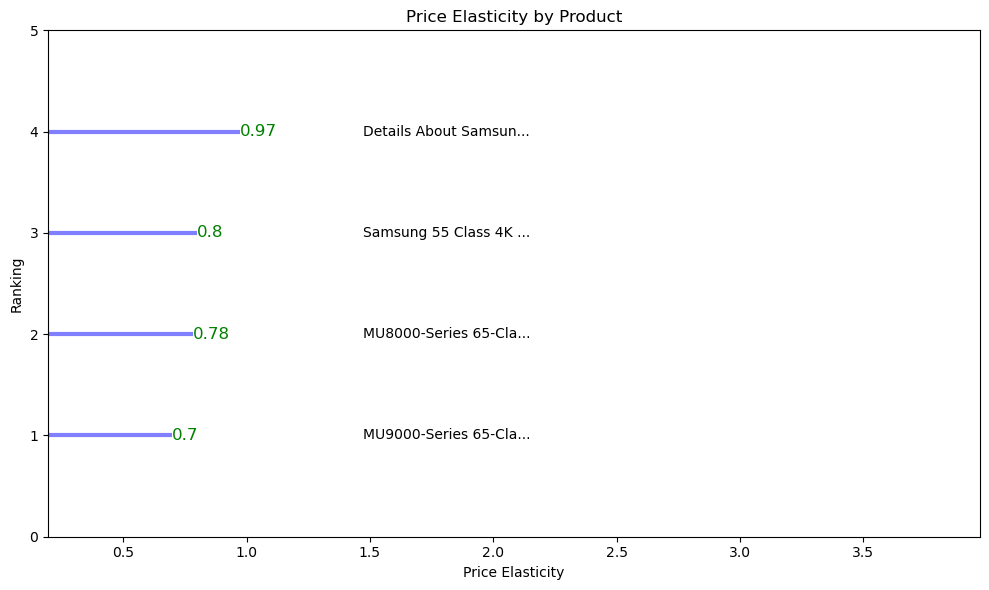

In [198]:
# Creating canvas
plt.figure(figsize=(10, 6))

# Plotting horizontal lines
plt.hlines(y=df_elasticity['ranking'], xmin=0, xmax=df_elasticity['price_elasticity'], alpha=0.5, linewidth=3, color='blue')

# Adding product names at the right end of the graph
for name, p in zip(df_elasticity['product_name'].str.slice(0, 20) + '...', df_elasticity['ranking']):
    plt.text(max(df_elasticity['price_elasticity']) + 0.5, p, name, verticalalignment='center')

# Creating elasticity labels
for x, y, s in zip(df_elasticity['price_elasticity'], df_elasticity['ranking'], df_elasticity['price_elasticity']):
    plt.text(x, y, round(s, 2), horizontalalignment='right' if x < 0 else 'left', 
             verticalalignment='center', fontdict={'color':'red' if x < 0 else 'green', 'size':12})

# Setting labels and title
plt.title('Price Elasticity by Product')
plt.xlabel('Price Elasticity')
plt.ylabel('Ranking')

# Adjusting the limits and layout
plt.xlim(min(df_elasticity['price_elasticity']) - 0.5, max(df_elasticity['price_elasticity']) + 3)  # Extra space on the right
plt.ylim(min(df_elasticity['ranking']) - 1, max(df_elasticity['ranking']) + 1)

# Show plot
plt.tight_layout()
plt.savefig('price_elasticity_by_product.png')
plt.show()


## 1.6 BUSINESS PERFORMANCE 

In [200]:
revenue_result = {
    'product_name': [],
    'yrly_revenue': [],
    'price_at_risk':[],
    'new_revenue':[],
    'revenue_variation':[],
    'pct_variation':[]
}

for i in range(len(df_elasticity)):
    yrly_mean_price     = x_price[df_elasticity['product_name'][i]].mean()
    yrly_demand         = y_demand[df_elasticity['product_name'][i]].sum()

    # applying a discount of 10% off
    discounted_price    = yrly_mean_price * 0.9
    new_demmand         = df_elasticity['price_elasticity'][i] * (-0.1)

    new_demmand         = yrly_demand + (yrly_demand*new_demmand)

    yrly_revenue        = yrly_mean_price * yrly_demand
    price_risk          = yrly_revenue - (yrly_revenue * 0.9)
    new_revenue         = discounted_price * new_demmand

    revenue_result['product_name'].append(df_elasticity['product_name'][i])
    revenue_result['yrly_revenue'].append(yrly_revenue)
    revenue_result['price_at_risk'].append(price_risk)
    revenue_result['new_revenue'].append(new_revenue)
    revenue_result['revenue_variation'].append(new_revenue - yrly_revenue)
    revenue_result['pct_variation'].append((new_revenue - yrly_revenue)/yrly_revenue)

# from dictionary to dataframe
revenue_result = pd.DataFrame.from_dict(revenue_result)

# a copy to use in the presentation
results = revenue_result.copy()

# formatting as monetary values
format_func = lambda x: '${:,.2f}'.format(x)
results[['yrly_revenue', 'price_at_risk', 'new_revenue', 'revenue_variation']] = results[['yrly_revenue', 'price_at_risk', 'new_revenue', 'revenue_variation']].applymap(format_func)

# formatting the 'pct_variation' column as percentage values
results['pct_variation'] = (results['pct_variation']*100).map('{:.2f}%'.format)

# displaying the results
results
# results = results.set_index('product_name')
# results.to_csv('results.csv')

,product_name,yrly_revenue,price_at_risk,new_revenue,revenue_variation,pct_variation
0,MU9000-Series 65-Class HDR UHD Smart LED TV,"$172,617.80","$17,261.78","$144,549.78","$-28,068.02",-16.26%
1,MU8000-Series 65-Class HDR UHD Smart LED TV,"$194,370.32","$19,437.03","$161,235.58","$-33,134.74",-17.05%
2,Samsung 55 Class 4K (2160P) Smart LED TV (UN55...,$578.94,$57.89,$479.34,$-99.60,-17.20%
3,Details About Samsung 24 Class Hd (720p) Smart...,"$2,803.19",$280.32,"$2,277.43",$-525.76,-18.76%


In [202]:
print('New incomming of ${:,.2f} annual revenue of LED TVs.'.format(revenue_result['revenue_variation'].sum()))

New incomming of $-61,828.12 annual revenue of LED TVs.


In [204]:
n = 1

print("""
The current revenue for product "{}" is {} annually. Considering a 10% promotion on the value of the product, we could lose something around {}.
 However, considering the high price elasticity of demand for the product, the demand for it grows, generating an increase of {} in revenue ({}), that is, a new revenue of {} annually.
      """.format(results.loc[n, :]['product_name'], results.loc[n, :]['yrly_revenue'], results.loc[n, :]['price_at_risk'], results.loc[n, :]['revenue_variation'], results.loc[n, :]['pct_variation'], results.loc[n, :]['new_revenue']
          ))


The current revenue for product "MU8000-Series 65-Class HDR UHD Smart LED TV" is $194,370.32 annually. Considering a 10% promotion on the value of the product, we could lose something around $19,437.03.
 However, considering the high price elasticity of demand for the product, the demand for it grows, generating an increase of $-33,134.74 in revenue (-17.05%), that is, a new revenue of $161,235.58 annually.
      


## 1.7 CROSS PRICE ELASTICITY

In [206]:
def crossprice(df_x, df_y, column_name):
    
    # all values from x_price
    aux1 = x_price.copy()

    # values from y_demand, with the same name as the column
    aux1['y_value-' + column_name] = y_demand[column_name]

    multi_xvalues = aux1.loc[:, aux1.columns[1:-1]]
    multi_yvalues = aux1.loc[:, aux1.columns[-1]]

    # obtaining mean values
    mean_xvalues = np.mean(multi_xvalues)
    mean_yvalues = np.mean(multi_yvalues)

    # linear regression
    X       = sm.add_constant(multi_xvalues)
    model   = sm.OLS(multi_yvalues, X, missing='drop')
    result  = model.fit()

    # obtaining results
    results_summary = result.summary()

    # obtaining p-values
    pvalue = result.pvalues

    # creating a dataframe
    results_as_html     = results_summary.tables[1].as_html()
    aux2       = pd.read_html(results_as_html, header=0, index_col=0)[0]

    # adding p-value to the dataframe
    aux2['p_value'] = pvalue

    # resetting index and changing it to 'name'
    aux2.index.name= 'name'
    aux2.reset_index()

    # calculating cross-prices
    aux2['mean'] = mean_xvalues
    aux2['price_elasticity'] = round((aux2.coef)*(aux2['mean']/mean_yvalues), 2)

    aux2 = aux2.reset_index()
    pvalue_siginicant = aux2['p_value']

    # verifying if the price elasticity is significant
    aux2[column_name + 'CPE'] = np.where((pvalue_siginicant > 0.05), 'No Effect', aux2['price_elasticity'])
    aux2 = aux2.dropna()
    return aux2[['name', column_name + 'CPE']]

# creating a dataframe
df_cross = pd.DataFrame()

# calculating cross-prices for each column
for column in x_price.columns[1:]:
    df_cross[['name_of_the_product', column]] = crossprice(x_price, y_demand, column)

# setting the index
df_cross = df_cross.set_index('name_of_the_product')

# displaying the results
df_cross

,"Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)""",MU8000-Series 65-Class HDR UHD Smart LED TV,MU9000-Series 65-Class HDR UHD Smart LED TV,"Samsung 55 Class 4K (2160P) Smart LED TV (UN55KU7000)"""
name_of_the_product,,,,
const,No Effect,No Effect,No Effect,No Effect
"Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)""",11.2,2.24,No Effect,No Effect
MU8000-Series 65-Class HDR UHD Smart LED TV,No Effect,0.49,No Effect,No Effect
MU9000-Series 65-Class HDR UHD Smart LED TV,No Effect,0.16,0.4,No Effect
"Samsung 55 Class 4K (2160P) Smart LED TV (UN55KU7000)""",No Effect,No Effect,No Effect,8.14


Analisys of Cross Price elasticity

- "No Effect": Cells marked as "No Effect" indicate that a change in the price of a TV model has no significant effect on the demand for the compared model.
- 11.2 in the row "Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)" and column "Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)": indicates that a 1% increase in the price of the model "Details About Samsung 24 Class Hd" would result in an 11.2% increase in demand for the same model, which would normally be considered on the main diagonal. 
- 2.24 in the row "Details About Samsung 24 Class Hd (720p) Smart Led Tv (un24m4500)" and column "MU8000-Series 65-Class HDR UHD Smart LED TV": suggests that a 1% increase in the price of "MU8000-Series 65-Class HDR UHD Smart LED TV" would lead to a 2.24% increase in demand for "Details About Samsung 24 Class Hd".
- 0.49 and 0.4: Indicate positive elasticities, suggesting that these products can be substitutes. An increase in the price of one can increase the demand for the other.

General Interpretation:

- If the value is positive, it means that the products are substitutes (an increase in the price of one increases the demand for the other).
- "No Effect" values indicate independence, where the price of one product does not affect the demand for the other.
- The analysis suggests that some of the products have significant effects on the demand for others, while many product pairs do not have relevant cross-elasticity. This can help to understand the competition between different TV models in the market.
